In [1]:
import cvxpy as cp
import scipy as sc
import numpy as np
import numpy.random as npr
import torch
from sklearn import datasets
import pandas as pd
import lro
import matplotlib.pyplot as plt
import warnings
import seaborn
import imageio
warnings.filterwarnings("ignore")
plt.rcParams.update({
    "text.usetex":True,
    
    "font.size":18,
    "font.family": "serif"
})
colors = ["tab:blue", "tab:green", "tab:orange", 
          "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:grey", "tab:olive"]

### Example 3: Max of affine uncertainty
We consider a problem with max of affine uncertainty, 

$$g(u,x) = \max_{l=1,\dots,L} (P_lu + a_l)^Tx,$$
where $P_l$ and $a_l$ are constants for all $l = 1, \dots, L$. The robust formulation is 
$$
\begin{array}{ll}
\text{minimize} & \tau\\
\text{subject to}  & \max_{l=1,\dots,L} (P_lu + a_l)^Tx  \leq  \tau \quad \forall u \in \mathcal{U}(\theta)\\
& x \geq 0,
\end{array}
$$


where $\theta$ encodes the training parameters $(A,b)$.

In [2]:
# Formulate constants
n = 2
N = 50
# k = npr.uniform(1,4,n)
# p = k + npr.uniform(2,5,n)
k = np.array([2.,3.])
p = np.array([3,4.5])
k_tch = torch.tensor(k, requires_grad = True)
p_tch = torch.tensor(p, requires_grad = True)

# Formulate loss function
def loss(t,x, data,l = 5): 
    return t + l*torch.mean(torch.maximum(
        torch.maximum(k_tch@x -data@p_tch, k_tch@x - p_tch@x) - t, 
        torch.tensor(0.,requires_grad = True))), t, torch.mean(torch.maximum(
        torch.maximum(k_tch@x -data@p_tch, k_tch@x - p_tch@x) - t, 
        torch.tensor(0.,requires_grad = True)))

def gen_demand(n, N):
    np.random.seed(7)
    F = np.random.normal(size = (n,2))
    sig = 0.1*F@(F.T)
    mu = np.random.uniform(-0.2,3,n)
    norms = np.random.multivariate_normal(mu,sig, N)
    d_train = np.exp(norms)
    return d_train

# Generate data
data = gen_demand(n,N)

### Plot Data

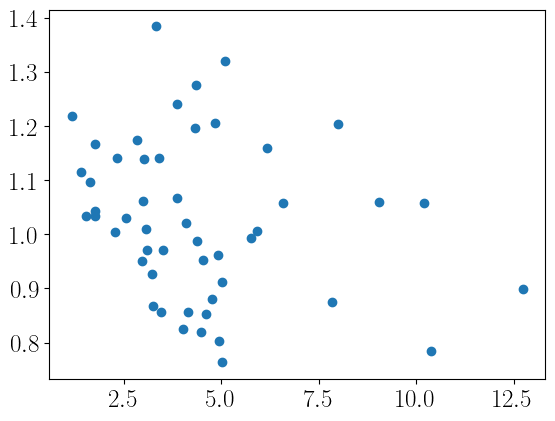

In [4]:
plt.scatter(data[:,0],data[:,1])

### Train relevant sets

In [10]:
n = 2
# Formulate uncertainty set
u = lro.UncertainParameter(n,
                        uncertainty_set=lro.Ellipsoidal(p=2,
                                                    data=data, loss = loss))
# Formulate the Robust Problem
x_r = cp.Variable(n)
t = cp.Variable()

objective = cp.Minimize(t)

constraints = [cp.maximum(k@x_r - p@x_r, k@x_r - p@u) <= t]
constraints += [x_r >= 0]

prob = lro.RobustProblem(objective, constraints)

s = 13
# # Train only epsilon
result = prob.train(eps = True, lr = 0.001, step=50, momentum = 0.8, optimizer = "SGD", initeps = 1, seed = s)
df_eps = result.df
# # Train A and b
init_A = sc.linalg.sqrtm(sc.linalg.inv(np.cov(data.T)))
init_b = -init_A@np.mean(data, axis=0)
# Train A and b
result1 = prob.train(lr = 0.001, step=250, momentum = 0.8, optimizer = "SGD", seed = s, initA = init_A, initb = init_b, save_iters = True)
df1 = result1.df
A_fin = result1.A
b_fin = result1.b

A1_iters, b1_iters = result1.uncset_iters

result2 = prob.train(eps = True, lr = 0.001, step=50, momentum = 0.8, optimizer = "SGD", seed = s, initA = A_fin, initb = b_fin, save_iters = True)
df_r1 = result2.df
A_fin_2 = result2.A
b_fin_2 = result2.b

result3 = prob.train(eps = True, lr = 0.001, step=50, momentum = 0.8, optimizer = "SGD", seed = s, initA = init_A, initb = init_b)
df_r2 = result3.df

# Grid search epsilon
result4 = prob.grid(epslst = np.linspace(0.01, 3, 40), initA = init_A, initb = init_b, seed = s)
dfgrid = result4.df

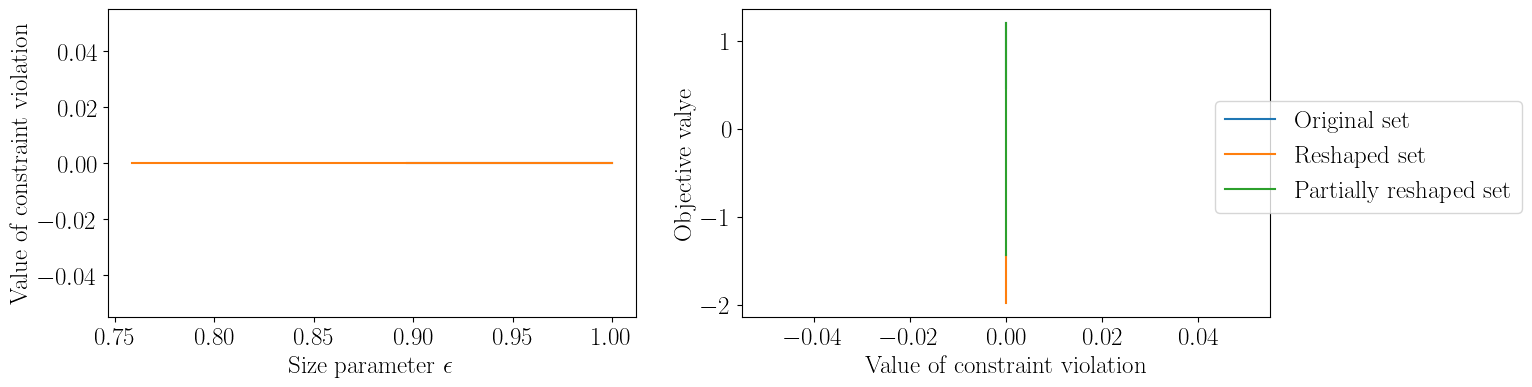

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
ax1.plot((df_r2['A_norm']), df_r2['Violations'], color="tab:blue", label=r"Original set")
ax1.plot((df_r1['A_norm']), df_r1['Violations'], color="tab:orange", label="Reshaped set")
# ax1.set_yscale("log")
ax1.set_xlabel("Size parameter $\epsilon$")
ax1.set_ylabel("Value of constraint violation")

ax2.plot(df_r2['Violations'][:], df_r2['Opt_val'][:], color="tab:blue", label=r"Original set")
ax2.plot(df_r1['Violations'],df_r1['Opt_val'], color="tab:orange", label="Reshaped set")
ax2.plot(df1['Violations'],df1['Opt_val'], color="tab:green", label="Partially reshaped set")
ax2.set_ylabel("Objective valye")
# ax2.set_xlim([-1,20])
ax2.set_xlabel("Value of constraint violation")
lgd = ax2.legend(loc = "lower right", bbox_to_anchor=(1.5, 0.3))
plt.savefig("tradeoff_curves.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

### Solve for final values

In [13]:
def final_solve(A_final, b_final):

    n = 2
    u = lro.UncertainParameter(n,
                            uncertainty_set=lro.Ellipsoidal(p=2,
                                                        A = A_final, b = b_final))
    # Formulate the Robust Problem
    x_r = cp.Variable(n)
    t = cp.Variable()

    objective = cp.Minimize(t)

    constraints = [cp.maximum(k@x_r - p@x_r, k@x_r - p@u) <= t]
    constraints += [x_r >= 0]

    prob = lro.RobustProblem(objective, constraints)
    prob.solve()
    # result3.reform_problem.solve()
    x_final = x_r.value
    t_final = t.value

    return x_final, t_final

x_opt_learned_2, t_opt_learned_2 = final_solve(A_fin_2, b_fin_2)
x_opt_learned, t_opt_learned = final_solve(A_fin, b_fin)
x_opt_base, t_opt_base = final_solve(init_A, init_b)

print("base x,t =", x_opt_base, t_opt_base)
print("optimal x,t =", x_opt_learned, t_opt_learned)
print("after eps train optimal x,t =", x_opt_learned_2, t_opt_learned_2)



base x,t = [2.86182346 2.05538129] 1.1954414361831998
optimal x,t = [1.60370149 1.40815337] -1.4302163725917236
after eps train optimal x,t = [1.56230937 1.43574812] -1.9821882119143184


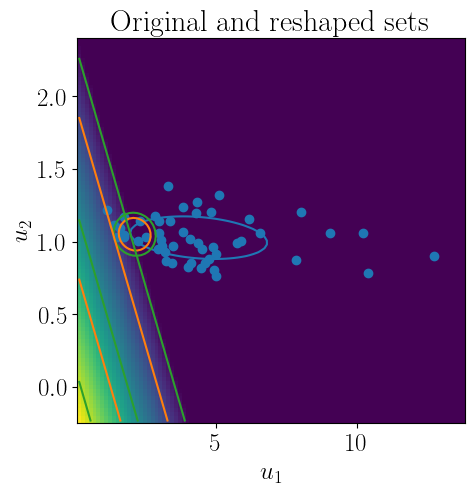

In [14]:
# Populate Z Values (a 7x7 matrix) - For a circle x^2+y^2=z
offset = 1
x_min, x_max = np.min(data[:,0]) - offset, np.max(data[:,0]) + offset
y_min, y_max = np.min(data[:,1]) - offset, np.max(data[:,1]) + offset
n_points = 100
X = np.linspace(x_min,x_max,n_points)
Y = np.linspace(y_min,y_max,n_points)
x_mesh,y_mesh = np.meshgrid(X,Y)

def level_set(A_final, b_final, offset = 2, n = n_points, x_mesh = x_mesh, y_mesh = y_mesh):
    x_opt, t_opt = final_solve(A_final, b_final)
    unc_level_set = np.zeros((n,n))
    g_level_set = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            u_vec = [x_mesh[i,j], y_mesh[i,j]]
            unc_level_set[i,j] = np.linalg.norm(A_final @ u_vec  + b_final)
            g_level_set[i,j] = np.maximum(k @ x_opt - p @ x_opt, k @ x_opt - p @ u_vec) - t_opt

    return unc_level_set, g_level_set


unc_level_learned_2, g_level_learned_2 = level_set(A_fin_2, b_fin_2)
unc_level_learned, g_level_learned = level_set(A_fin, b_fin)
unc_level_base, g_level_base = level_set(init_A, init_b)



plt.figure(figsize=(5, 5))
plt.title("Original and reshaped sets")
# Set axis label for the contour plot
plt.xlabel(r"$u_1$")
plt.ylabel(r"$u_2$")

plt.contour(x_mesh,y_mesh,unc_level_base, [1], colors = ["tab:blue"], label = "initial sets")
plt.contour(x_mesh,y_mesh,unc_level_learned, [1], colors = ["tab:green"], label = "initial train A,b")
plt.contour(x_mesh,y_mesh,unc_level_learned_2, [1], colors = ["tab:orange"], label = "final train")

# plt.pcolormesh(x_mesh, y_mesh,g_level_learned)
plt.contour(x_mesh,y_mesh,g_level_learned, [0, 5, 10], colors = ["tab:orange"])
plt.contour(x_mesh,y_mesh,g_level_base, [0, 5, 10], colors = ["tab:green"])
plt.scatter(data[:,0],data[:,1])
# plt.savefig("Reshaped_ctrs.pdf", bbox_inches='tight')
# plt.legend(loc = "upper center")
plt.show()



In [51]:
import os
import imageio

filenames = []
for i in range(len(A1_iters)):
    unc_level, g_level = level_set(A1_iters[i], b1_iters[i])
    plt.figure(figsize=(5, 5))
    plt.title("Original and reshaped sets")
    # Set axis label for the contour plot
    plt.xlabel(r"$u_1$")
    plt.ylabel(r"$u_2$")

    plt.contour(x_mesh,y_mesh,unc_level_base, [1], colors = ["tab:blue"], label = "initial sets")
    plt.contour(x_mesh,y_mesh,unc_level, [1], colors = ["tab:orange"], label = "final train")
    plt.contour(x_mesh,y_mesh,unc_level_learned, [1], colors = ["tab:green"], label = "initial train A,b")

    filename = f'gif_images/{i}.png'
    filenames.append(filename)

    plt.scatter(data[:,0],data[:,1])
    plt.savefig(filename)
    plt.close()

with imageio.get_writer('mygif4.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)


    

## MRO set

In [5]:
n = 2
# Formulate uncertainty set
u = lro.UncertainParameter(n,
                        uncertainty_set=lro.MRO(p=2,
                                                    data=data, loss = loss))
# Formulate the Robust Problem
x_r = cp.Variable(n)
t = cp.Variable()

objective = cp.Minimize(t)

constraints = [cp.maximum(k@x_r - p@x_r, k@x_r - p@u) <= t]
constraints += [x_r >= 0]

prob = lro.RobustProblem(objective, constraints)

s = 13
# # Train only epsilon
result = prob.train(eps = True, lr = 0.001, step=50, momentum = 0.8, optimizer = "SGD", initeps = 1, seed = s)
df_eps = result.df
# # Train A and b
init_A = sc.linalg.sqrtm(sc.linalg.inv(np.cov(data.T)))
init_b = -init_A@np.mean(data, axis=0)
# Train A and b
result1 = prob.train(lr = 0.001, step=30, momentum = 0.8, optimizer = "SGD", seed = s, initA = init_A, initb = init_b)
df1 = result1.df
A_fin = result1.A
b_fin = result1.b

A1_iters, b1_iters = result1.uncset_iters

result2 = prob.train(eps = True, lr = 0.001, step=50, momentum = 0.8, optimizer = "SGD", seed = s, initA = A_fin, initb = b_fin)
df_r1 = result2.df
A_fin_2 = result2.A
b_fin_2 = result2.b

result3 = prob.train(eps = True, lr = 0.001, step=50, momentum = 0.8, optimizer = "SGD", seed = s, initA = init_A, initb = init_b )
df_r2 = result3.df

# Grid search epsilon
result4 = prob.grid(epslst = np.linspace(0.01, 3, 40), initA = init_A, initb = init_b, seed = s)
dfgrid = result4.df

In [114]:
# Formulate constants
n = 2
N = 50
# k = npr.uniform(1,4,n)
# p = k + npr.uniform(2,5,n)
k = np.array([2.,3.])
p = np.array([3,4.5])
k_tch = torch.tensor(k, requires_grad = True)
p_tch = torch.tensor(p, requires_grad = True)

# Formulate loss function
def loss(t,x, data,l = 5): 
    return t + l*torch.mean(torch.maximum(
        torch.maximum(k_tch@x -data@p_tch, k_tch@x - p_tch@x) - t, 
        torch.tensor(0.,requires_grad = True))), t, torch.mean(torch.maximum(
        torch.maximum(k_tch@x -data@p_tch, k_tch@x - p_tch@x) - t, 
        torch.tensor(0.,requires_grad = True)))

def gen_demand(n, N):
    np.random.seed(2)
    F = np.random.normal(size = (n,2))
    sig = 0.1*F@(F.T)
    mu = np.random.uniform(-0.2,3,n)
    norms = np.random.multivariate_normal(mu,sig, N)
    d_train = np.exp(norms)
    return d_train

# Generate data
data = gen_demand(n,N)